# tvArch1
## 1500 replications
###### Author: Mokhtar Z. Alaya <alayaelm@utc.fr>

In [1]:
import sys
sys.path.append('D:/Users/tiniojan/ExperimentsPhD/June_19_24/wasslsp')
import warnings
warnings.filterwarnings('ignore')


import numpy as np
import scipy as scp

import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
%matplotlib inline
#from matplotlib import rc
#rc('font', **{'family': 'sans-serif', 'sans-serif': ['Computer Modern Roman']})
params = {'axes.labelsize': 12,
          'font.size': 12,
          'legend.fontsize': 12,
          'xtick.labelsize': 12,
          'ytick.labelsize': 8, # 10
          'text.usetex': True,
          'figure.figsize': (10, 8)}
plt.rcParams.update(params)

import seaborn as sns

from src.utils import *
from src.kernels import Kernel

from scipy.stats import wasserstein_distance
from mpl_toolkits.mplot3d import Axes3D

In [3]:
import torch

# Plot process

In [5]:
T = 1000
n_replications = 1
d = 1


phi0 = lambda u: 0.4 + 0.2 * np.sin(2 * np.pi * u)  
phi1 = lambda u: 0.5 + 0.3 * np.sin(2 * np.pi * u)  
sigma_star = lambda u: 1.0

# Generate m_star
m_star = lambda u, U, x: (np.sqrt(phi0(u) + phi1(u)*(x**2))) * U

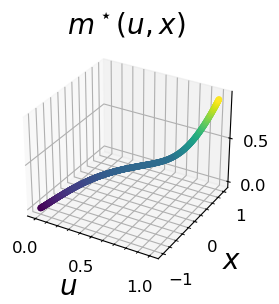

In [7]:
# Plot of m^star
plt.rcParams['text.usetex'] = False

u = np.linspace(0., 1., T)
U = np.linspace(0, 1., T)
x = np.linspace(-1., 1., T)
u_mesh, x_mesh = np.meshgrid(u, x)

m_star_vals_mesh = m_star(u_mesh, U, x_mesh)
m_star_vals = m_star(u, U, x)
# ax = plt.axes(projection='3d')
# ax.plot3D(u, x, m_star_vals, 'gray')
# plt.show()
plt.rcParams["figure.figsize"] = (10,3)
fig = plt.figure()
ax = plt.axes(projection='3d')
plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
plt.minorticks_on()
# ax.contour3D(u_mesh, y_mesh, m_star_vals_mesh, 50, cmap='binary')
ax.scatter(u, x, m_star_vals, c=m_star_vals, cmap='viridis', linewidth=0.1);
ax.set_xlabel(r'$u$', fontsize=20)
ax.set_ylabel(r'$x$', fontsize=20)
ax.set_title(r'$m^\star(u,x)$', fontsize=20)
#plt.savefig("m_star_tvQR_1.pdf", dpi=300)
plt.tight_layout()
plt.show()

In [9]:

T = 1000
n_replications = 1
d = 1


X_tvarch_1 = np.zeros(T)
X_tvarch_1_mean = np.zeros(T)
mu = np.zeros(T)

X_tvarch_1_replications = np.zeros((n_replications, T))
mu_tvarch_1_replications = np.zeros((n_replications, T))

X_dict = {}

for replication in range(n_replications):
    t = 1
    epsilon = np.random.normal(size=(T))
    X = np.zeros((T,d))
    while t <= T-1 :
        X_tvarch_1[t] = m_star((t/T), epsilon[t-1], X_tvarch_1[t-1]) + sigma_star(t/T) * epsilon[t]
        mu[t] = m_star((t/T), epsilon[t-1], X_tvarch_1[t-1])
        X[t] = [X_tvarch_1[t-1]]
        t += 1
        
    X_dict[str(replication)] = X
    X_tvarch_1_replications[replication] = X_tvarch_1
    mu_tvarch_1_replications[replication] = mu

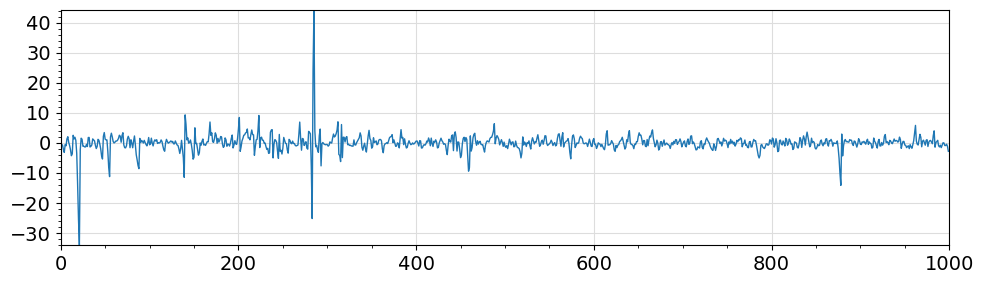

In [11]:
#path_fig = 'D:/ExperimentsPhD/Experiment results'
plt.rcParams["figure.figsize"] = (10,3)

u_var = np.linspace(0., 1., T)

for replication in range(n_replications):
    plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
    plt.minorticks_on()
    plt.plot(X_tvarch_1_replications[replication], lw=1)
    # plt.plot(X_tvar_2_replications_u_var[replication], lw=2)
    # plt.plot(X_tvar_2_mean)
    # plt.xticks(np.arange(0, T+1, 200, dtype=int))
    plt.xlim(0, T)
    plt.ylim(min(X_tvarch_1_replications[replication]) , max(X_tvarch_1_replications[replication]))
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    # plt.title(r'$Y_{t,T} = m^\star(\frac{t}{T}, X_{t,T}) + \varepsilon_{t,T}$')
    # plt.legend()
    plt.tight_layout()
    #plt.savefig(path_fig+"tv_AR_2_gaussian.pdf", dpi=300)

## NW estimator for the conditional mean function

Note that NW estimator of $m^\star(u,\boldsymbol{x})$ is given by  $\hat m(u,\boldsymbol{x}) 
% = \E_{\hat{\pi}_t(\cdot|\boldsymbol{x})}[Y_{t,T}| \boldsymbol{X}_{t,T}=\boldsymbol{x}]
= \sum_{a=1}^T   \omega_{a}(u, \boldsymbol{x}) Y_{a,T}$.

In [13]:
space_kernel = "gaussian"
time_kernel = "uniform"
bandwidth = T **(-0.4 / (d+1))
Y_t_T = X_tvarch_1_replications[0]

GaussUnifKernel = Kernel(T=T, bandwidth=bandwidth, space_kernel=space_kernel, time_kernel=time_kernel)
GaussUnifKernel 

Kernel(T=1000, bandwidth=0.251188643150958, time_kernel='uniform')

In [15]:
weights = {}
for t in range(T):
    weights[str(t)] = GaussUnifKernel.fit(X_dict['0'], t)

In [17]:
weights['0'].shape, Y_t_T.shape

((1000,), (1000,))

In [19]:
m_hat= [np.sum(weights[str(t)] * Y_t_T) for t in range(T)]
# for t in range(T): m_hat.append(np.sum(weights[str(t)] * Y_t_T))

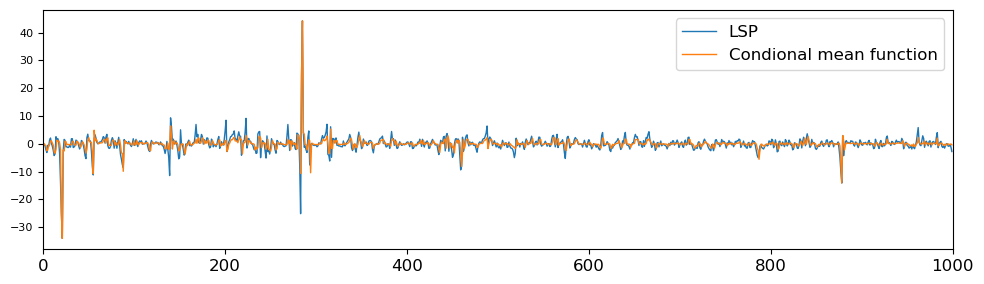

In [21]:
#path_fig = "/Users/mzalaya/Library/CloudStorage/Dropbox/research/git/wasslsp/figs/"
plt.rcParams["figure.figsize"] = (10,3)

u_var = np.linspace(0., 1., T)

for replication in range(n_replications):
    plt.plot(X_tvarch_1_replications[replication], lw=1, label="LSP")
    plt.plot(np.array(m_hat), lw=1, label="Condional mean function")
    # plt.plot(X_tvar_2_replications_u_var[replication], lw=2)
    # plt.plot(X_tvar_2_mean)
    # plt.xticks(np.arange(0, T+1, 200, dtype=int))
    plt.xlim(0, T)
    # plt.title(r'$Y_{t,T} = m^\star(\frac{t}{T}, X_{t,T}) + \varepsilon_{t,T}$')
    plt.legend()
    plt.tight_layout()
    #plt.savefig(path_fig+"locally_process_conditional_mean_Guassina_space_kernel_uniform_tiem_kernel.pdf", dpi=150)

In [15]:
## Dimensions

In [23]:
times_T = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
times_t = [150, 200, 250, 300, 350, 400, 450, 500] 

d = 1
n_replications = 1500

In [25]:

X_tvarch_1 = {}
X_tvarch_1_replications = {}
X_dict = {}
mu = {}
mu_replications = {}

# "T:"+str(T
for T in times_T:
    X_tvarch_1_replications[f"T:{T}"] = np.zeros((n_replications, T))
    mu_replications[f"T:{T}"] = np.zeros((n_replications, T))
    X_dict[f"T:{T}"] = {}

In [27]:
for T in times_T:
    u_var = np.linspace(0., 1., T)

    for replication in range(n_replications):
        t = 1
        epsilon = np.random.normal(size=(T))
        X = np.zeros((T,d))
        X_tvarch_1_T = np.zeros(T)
        mu = np.zeros(T)
        while t <= T-1 :
            X_tvarch_1_T[t] = m_star((t/T), epsilon[t-1], X_tvarch_1_T[t-1]) + sigma_star((t/T)) * epsilon[t]
            #mu[t] = m_star((t/T), epsilon[t], X_tvarch_1_T[t-1])
            X[t] = [X_tvarch_1_T[t-1]]
            t += 1

        X_tvarch_1_replications[f"T:{T}"][replication] = X_tvarch_1_T
        mu_replications[f"T:{T}"][replication] = mu
        X_dict[f"T:{T}"][str(replication)] = X

In [28]:
X_tvarch_1 = {}


#for t in times_t:
#    for T in times_T:
#        X_tvarch_1[f"t:{t}_T:{T}"] = {}
#        mu[f"t:{t}_T:{T}"] = {}

# X_tvar_2

In [29]:
for t in times_t:
    for T in times_T:
        X_tvarch_1[f"t:{t}_T:{T}"] = []


for t in times_t:
    for replication in range(n_replications):
        for T in times_T:
            z = X_tvarch_1_replications[f"T:{T}"][replication][t-1]
            X_tvarch_1[f"t:{t}_T:{T}"].append(z)

for t in times_t:
    for T in times_T:
        X_tvarch_1[f"t:{t}_T:{T}"] = np.array(X_tvarch_1[f"t:{t}_T:{T}"])

In [30]:
plt.rcParams["figure.figsize"] = (5,4)

norm_X_tvarch_1 = {}
for t in times_t:
    for T in times_T:
        norm_X_tvarch_1[f"t:{t}_T:{T}"] = scp.stats.norm.cdf(X_tvarch_1[f"t:{t}_T:{T}"])


# Nadara-Watson estimator: Gaussian kernel

In [31]:
space_kernel = "gaussian"
time_kernel = "uniform"
xi = 0.4 / (2*(d+1))

gaussian_kernel = {}
gaussian_weights = {}

for t in times_t:
    for T in times_T:
        gaussian_weights[f"t:{t}_T:{T}"] = {}
    
for T in times_T:
    bandwidth = T **(-xi) #/ 2
    gaussian_kernel[f"T:{T}"] = Kernel(T=T, bandwidth=bandwidth, space_kernel=space_kernel, time_kernel=time_kernel)

In [32]:
gaussian_kernel

{'T:1000': Kernel(T=1000, bandwidth=0.5011872336272722, time_kernel='uniform'),
 'T:2000': Kernel(T=2000, bandwidth=0.46762422391131064, time_kernel='uniform'),
 'T:3000': Kernel(T=3000, bandwidth=0.4490429419325431, time_kernel='uniform'),
 'T:4000': Kernel(T=4000, bandwidth=0.436308828551048, time_kernel='uniform'),
 'T:5000': Kernel(T=5000, bandwidth=0.42668070064464836, time_kernel='uniform'),
 'T:6000': Kernel(T=6000, bandwidth=0.4189718794398096, time_kernel='uniform'),
 'T:7000': Kernel(T=7000, bandwidth=0.41256292359026653, time_kernel='uniform'),
 'T:8000': Kernel(T=8000, bandwidth=0.4070905315369044, time_kernel='uniform'),
 'T:9000': Kernel(T=9000, bandwidth=0.4023238226562461, time_kernel='uniform'),
 'T:10000': Kernel(T=10000, bandwidth=0.3981071705534972, time_kernel='uniform')}

In [33]:
for replication in range(n_replications):
    for t in times_t:
        for T in times_T:
            # print(X_dict[f"T:{T}"][str(replication)].shape, "\n")
            # print(gaussian_kernel[f"T:{T}"], "\n")
            # print(gaussian_weights[f"t:{t}_T:{T}"], "\n")
            gaussian_weights[f"t:{t}_T:{T}"][str(replication)] = \
            gaussian_kernel[f"T:{T}"].fit(X_dict[f"T:{T}"][str(replication)], t-1)

In [34]:
n_replications

1500

In [35]:
gaussian_weights_tensor =  {} #= torch.empty((len(times_t), len(times_T), )

# torch.zeros((len(times_t), len(times_T), n_replications, None))
# gaussian_weights_tensor.size() # torch.Size([len(times_t), len(times_T), n_replications])

for i_t in range(len(times_t)):
    for i_T in range(len(times_T)):
        gaussian_weights_tensor[f"t:{times_t[i_t]}_T:{times_T[i_T]}"] = {}


for i_t in range(len(times_t)):
    for i_T in range(len(times_T)):  
        for replication in range(n_replications):
            gaussian_weights_tensor[f"t:{times_t[i_t]}_T:{times_T[i_T]}"][str(replication)] =\
            gaussian_weights[f"t:{times_t[i_t]}_T:{times_T[i_T]}"][str(replication)]

\begin{align}
  \omega_{a}(\frac t T, \boldsymbol{x})=\frac{\displaystyle  K_{h,1}(\frac{t}{T} - \frac{a}{T})\prod_{j=1}^dK_{h,2}(x^j- X_{a,T}^j)}{\displaystyle \sum_{a=1}^TK_{h,1}(\frac{t}{T} - \frac{a}{T})\prod_{j=1}^dK_{h,2}(x^j - X_{a,T}^j)}.
 \end{align}

The associated conditional CDF to $\hat{\pi}_t(\cdot|\boldsymbol{x})$ is defined as, for all $y \in \R,$  
\begin{equation}
  \hat{F}_{t}(y|\boldsymbol{x})=\sum_{a=1}^T\omega_{a}(\frac tT,\boldsymbol{x}) \mathbf{1}_{Y_{a,T}\leq y}. %, \quad \text{for all $y\in\R$}. %  \ind{}(Y_{a,T}\leq y) 
\end{equation}


In [36]:
empirical_cds = {}
for t in times_t:
    for T in times_T:
        empirical_cds[f"t:{t}_T:{T}"] = scp.stats.norm.cdf(X_tvarch_1[f"t:{t}_T:{T}"])


In [37]:
def eval_univariate(x, weights):
        """Inner function for ECDF of one variable."""
        sorter = x.argsort()
        x = x[sorter]
        weights = weights[sorter]
        y = weights.cumsum()

        # if self.stat in ["percent", "proportion"]:
        y = y / y.max()
        # if self.stat == "percent":
            # y = y * 100

        # x = np.r_[-np.inf, x]
        # y = np.r_[0, y]
        x = np.r_[x]
        y = np.r_[y]

        # if self.complementary:
            # y = y.max() - y

        return y, x

In [38]:


x_rep = {} 
y_rep = {} 

wasserstein_distances = {}

for t in times_t:
    for T in times_T:
        x_rep[f"t:{t}_T:{str(T)}"] = np.zeros((n_replications, T))
        y_rep[f"t:{t}_T:{str(T)}"] = np.zeros((n_replications, T))
        wasserstein_distances[f"t:{t}_T:{T}"] = {}

for replication in range(n_replications): #range(n_replications): #range(n_replications):
   # sns.lineplot(x=X_tvar_2_replications[replication], y=replicated_NW_cdfs_100[str(replication)])
   # plt.ecdf(X_tvar_2_replications[replication], weights=weights_100[str(replication)][99])
   # sns.ecdfplot(data=None, x=X_tvar_2_replications[replication], weights=weights_100[str(replication)][99])
   # data = X_tvar_2_replications[replication] * weights_100[str(replication)][99]
   # plt.plot(np.sort(a), np.linspace(0., 1., len(a), endpoint=False), c='g',lw=2)
   # plt.plot(np.sort(data), np.arange(1, len(data)+1) / len(data))
    for t in times_t:
        for T in times_T:
            y, x = eval_univariate(
                X_tvarch_1_replications[f"T:{T}"][replication], gaussian_weights_tensor[f"t:{t}_T:{str(T)}"][str(replication)]
                # gaussian_weights_tensor[f"t:{t}_T:{str(T)}"][str(replication)] * X_tvar_2_replications[f"T:{T}"][replication]
            )
            x_rep[f"t:{t}_T:{str(T)}"][replication] = x
            y_rep[f"t:{t}_T:{str(T)}"][replication] = y
            distance = wasserstein_distance(y, scp.stats.norm.cdf(X_tvarch_1_replications[f"T:{T}"][replication]))
            wasserstein_distances[f"t:{t}_T:{T}"][str(replication)] = distance
   
   
            #plt.plot(x, y, label=f"t:{t}_T:{T}")# _replication:{replication}")
            #plt.xlabel(r'$y$')
            #plt.ylabel(r'$\hat{F}_t(y|x)$')
            ## plt.xticks(np.arange(0, T+1, 200, dtype=int))
            ##plt.xlim(-18, 18)
            #plt.title(r'NW CDF estimators, $\hat{F}_{t}(y|{x})=\sum_{a=1}^T\omega_{a}(\frac{t}{T},{x})\mathbf{1}_{Y_{a,T}\leq y}$')
            #plt.legend()
            #plt.tight_layout()
            ##plt.savefig(path_fig+"nadar_watson_weights_", dpi=150)

In [39]:
wass_distances_all_replications = {}

for t in times_t:
    for T in times_T:
        wass_distances_all_replications[f"t:{t}_T:{T}"] = []

for t in times_t:
    for T in times_T:       
        for replications in range(n_replications):
            wass_distances_all_replications[f"t:{t}_T:{T}"].append(wasserstein_distances[f"t:{t}_T:{T}"][str(replication)])
        

In [40]:
plt.rcParams["figure.figsize"] = (10,3)
wass_distances_empirical_meanNW = {}
for t in times_t:
    for T in times_T:
        wass_distances_empirical_meanNW[f"t:{t}_T:{T}"] = wasserstein_distance(
            empirical_cds[f"t:{t}_T:{T}"], y_rep[f"t:{t}_T:{T}"].mean(axis=0)
        )

In [41]:
wass_distances_empirical_meanNW

{'t:150_T:1000': 0.11336520069602503,
 't:150_T:2000': 0.09326561492387475,
 't:150_T:3000': 0.09386192704073235,
 't:150_T:4000': 0.08968006612977084,
 't:150_T:5000': 0.08917979157288428,
 't:150_T:6000': 0.09093900939504213,
 't:150_T:7000': 0.0818726246998147,
 't:150_T:8000': 0.08590872702660918,
 't:150_T:9000': 0.08870148369284861,
 't:150_T:10000': 0.0842136421740263,
 't:200_T:1000': 0.11149209089859108,
 't:200_T:2000': 0.10631395884129978,
 't:200_T:3000': 0.09748273879653521,
 't:200_T:4000': 0.09244719637270932,
 't:200_T:5000': 0.09700125617025149,
 't:200_T:6000': 0.0929758098622332,
 't:200_T:7000': 0.08360068360075855,
 't:200_T:8000': 0.08702930801033114,
 't:200_T:9000': 0.10019173278943605,
 't:200_T:10000': 0.08848661742534761,
 't:250_T:1000': 0.11567210023103683,
 't:250_T:2000': 0.10740027392418015,
 't:250_T:3000': 0.1060998087908599,
 't:250_T:4000': 0.0982754528569296,
 't:250_T:5000': 0.08786428728023175,
 't:250_T:6000': 0.09050111967656757,
 't:250_T:7000'

In [42]:
plt.rcParams["figure.figsize"] = (10,3)
wass_times_t = {}

for t in times_t:
    wass_times_t[f"t:{t}"] = []

for t in times_t:
    for T in times_T:
        wass_times_t[f"t:{t}"].append(wass_distances_empirical_meanNW[f"t:{t}_T:{T}"])

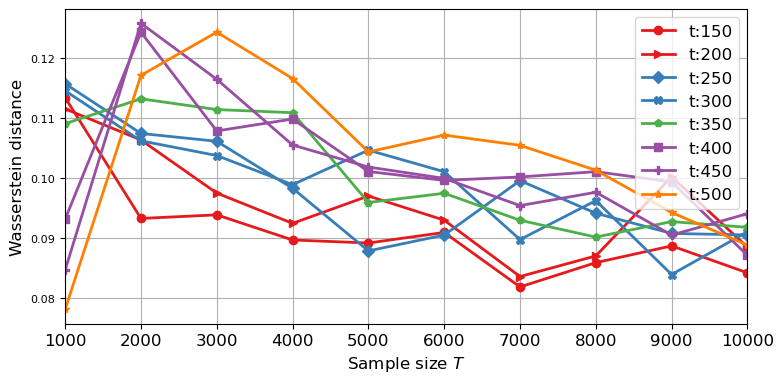

In [43]:

plt.rcParams["figure.figsize"] = (8,4)
colors = plt.cm.Set1(np.linspace(0, .5, 8))
#markers = ['o', '>', 'D', 'X', "p"]
markers = ['o', '>', 'D', 'X', "p", 's', 'P', '*'] 

for i, t in zip(range(len(times_t)), times_t):
    plt.plot(times_T, wass_times_t[f"t:{t}"], label=f"t:{t}", color=colors[i], marker=markers[i], markersize=6, lw=2)
    plt.xlim(np.array(times_T).min(), np.array(times_T).max())
    #plt.title(r'Wasserstein distance $W_1\left(\hat{\pi}_t(\cdot|{x}), \pi_t^\star(\cdot|{x})\right)$')
    plt.xlabel(r'Sample size ${T}$ ')
    plt.ylabel("Wasserstein distance")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    #plt.savefig(path_fig+f"wass_distance{times_t}{times_T}_{n_replications}_kernel_{kernel}", dpi=150)

# K1=tricube ; K2=silverman

In [39]:
space_kernel = "silverman"
time_kernel = "tricube"
xi = 0.4 / (2*(d+1))

gaussian_kernel = {}
gaussian_weights = {}

for t in times_t:
    for T in times_T:
        gaussian_weights[f"t:{t}_T:{T}"] = {}
    
for T in times_T:
    bandwidth = T **(-xi) / 2
    gaussian_kernel[f"T:{T}"] = Kernel(T=T, bandwidth=bandwidth, space_kernel=space_kernel, time_kernel=time_kernel)

In [40]:
for replication in range(n_replications):
    for t in times_t:
        for T in times_T:
            # print(X_dict[f"T:{T}"][str(replication)].shape, "\n")
            # print(gaussian_kernel[f"T:{T}"], "\n")
            # print(gaussian_weights[f"t:{t}_T:{T}"], "\n")
            gaussian_weights[f"t:{t}_T:{T}"][str(replication)] = \
            gaussian_kernel[f"T:{T}"].fit(X_dict[f"T:{T}"][str(replication)], t-1)

In [41]:
gaussian_weights_tensor =  {} #= torch.empty((len(times_t), len(times_T), )

# torch.zeros((len(times_t), len(times_T), n_replications, None))
# gaussian_weights_tensor.size() # torch.Size([len(times_t), len(times_T), n_replications])

for i_t in range(len(times_t)):
    for i_T in range(len(times_T)):
        gaussian_weights_tensor[f"t:{times_t[i_t]}_T:{times_T[i_T]}"] = {}


for i_t in range(len(times_t)):
    for i_T in range(len(times_T)):  
        for replication in range(n_replications):
            gaussian_weights_tensor[f"t:{times_t[i_t]}_T:{times_T[i_T]}"][str(replication)] =\
            gaussian_weights[f"t:{times_t[i_t]}_T:{times_T[i_T]}"][str(replication)]

In [42]:
empirical_cds = {}
for t in times_t:
    for T in times_T:
        empirical_cds[f"t:{t}_T:{T}"] = scp.stats.norm.cdf(X_tvarch_1[f"t:{t}_T:{T}"])


In [43]:


x_rep = {} 
y_rep = {} 

wasserstein_distances = {}

for t in times_t:
    for T in times_T:
        x_rep[f"t:{t}_T:{str(T)}"] = np.zeros((n_replications, T))
        y_rep[f"t:{t}_T:{str(T)}"] = np.zeros((n_replications, T))
        wasserstein_distances[f"t:{t}_T:{T}"] = {}

for replication in range(n_replications): #range(n_replications): #range(n_replications):
   # sns.lineplot(x=X_tvar_2_replications[replication], y=replicated_NW_cdfs_100[str(replication)])
   # plt.ecdf(X_tvar_2_replications[replication], weights=weights_100[str(replication)][99])
   # sns.ecdfplot(data=None, x=X_tvar_2_replications[replication], weights=weights_100[str(replication)][99])
   # data = X_tvar_2_replications[replication] * weights_100[str(replication)][99]
   # plt.plot(np.sort(a), np.linspace(0., 1., len(a), endpoint=False), c='g',lw=2)
   # plt.plot(np.sort(data), np.arange(1, len(data)+1) / len(data))
    for t in times_t:
        for T in times_T:
            y, x = eval_univariate(
                X_tvarch_1_replications[f"T:{T}"][replication], gaussian_weights_tensor[f"t:{t}_T:{str(T)}"][str(replication)]
                # gaussian_weights_tensor[f"t:{t}_T:{str(T)}"][str(replication)] * X_tvar_2_replications[f"T:{T}"][replication]
            )
            x_rep[f"t:{t}_T:{str(T)}"][replication] = x
            y_rep[f"t:{t}_T:{str(T)}"][replication] = y
            distance = wasserstein_distance(y, scp.stats.norm.cdf(X_tvarch_1_replications[f"T:{T}"][replication]))
            wasserstein_distances[f"t:{t}_T:{T}"][str(replication)] = distance
   
   
            #plt.plot(x, y, label=f"t:{t}_T:{T}")# _replication:{replication}")
            #plt.xlabel(r'$y$')
            #plt.ylabel(r'$\hat{F}_t(y|x)$')
            ## plt.xticks(np.arange(0, T+1, 200, dtype=int))
            ##plt.xlim(-18, 18)
            #plt.title(r'NW CDF estimators, $\hat{F}_{t}(y|{x})=\sum_{a=1}^T\omega_{a}(\frac{t}{T},{x})\mathbf{1}_{Y_{a,T}\leq y}$')
            #plt.legend()
            #plt.tight_layout()
            ##plt.savefig(path_fig+"nadar_watson_weights_", dpi=150)

In [44]:
wass_distances_all_replications = {}

for t in times_t:
    for T in times_T:
        wass_distances_all_replications[f"t:{t}_T:{T}"] = []

for t in times_t:
    for T in times_T:       
        for replications in range(n_replications):
            wass_distances_all_replications[f"t:{t}_T:{T}"].append(wasserstein_distances[f"t:{t}_T:{T}"][str(replication)])
        

In [45]:
plt.rcParams["figure.figsize"] = (10,3)
wass_distances_empirical_meanNW = {}
for t in times_t:
    for T in times_T:
        wass_distances_empirical_meanNW[f"t:{t}_T:{T}"] = wasserstein_distance(
            empirical_cds[f"t:{t}_T:{T}"], y_rep[f"t:{t}_T:{T}"].mean(axis=0)
        )

In [46]:
wass_distances_empirical_meanNW

{'t:150_T:1000': 0.10890122901601898,
 't:150_T:2000': 0.10187555322154285,
 't:150_T:3000': 0.09036785469737427,
 't:150_T:4000': 0.09632181211454854,
 't:150_T:5000': 0.10966744535124755,
 't:150_T:6000': 0.08319594192493188,
 't:150_T:7000': 0.09626530730488689,
 't:150_T:8000': 0.0953380004520424,
 't:150_T:9000': 0.0697796055316343,
 't:150_T:10000': 0.07699440439403488,
 't:200_T:1000': 0.12627582125944048,
 't:200_T:2000': 0.11057735595588092,
 't:200_T:3000': 0.09509537682289532,
 't:200_T:4000': 0.09892368513968228,
 't:200_T:5000': 0.08896077656270508,
 't:200_T:6000': 0.09064728452127713,
 't:200_T:7000': 0.0776415922618694,
 't:200_T:8000': 0.08880129477973767,
 't:200_T:9000': 0.09410802894753001,
 't:200_T:10000': 0.08224017160910078,
 't:250_T:1000': 0.1564391316303344,
 't:250_T:2000': 0.11226047254016173,
 't:250_T:3000': 0.1128641640321024,
 't:250_T:4000': 0.09730195654300888,
 't:250_T:5000': 0.10520693177832313,
 't:250_T:6000': 0.09253258212246311,
 't:250_T:7000'

In [47]:
plt.rcParams["figure.figsize"] = (10,3)
wass_times_t = {}

for t in times_t:
    wass_times_t[f"t:{t}"] = []

for t in times_t:
    for T in times_T:
        wass_times_t[f"t:{t}"].append(wass_distances_empirical_meanNW[f"t:{t}_T:{T}"])

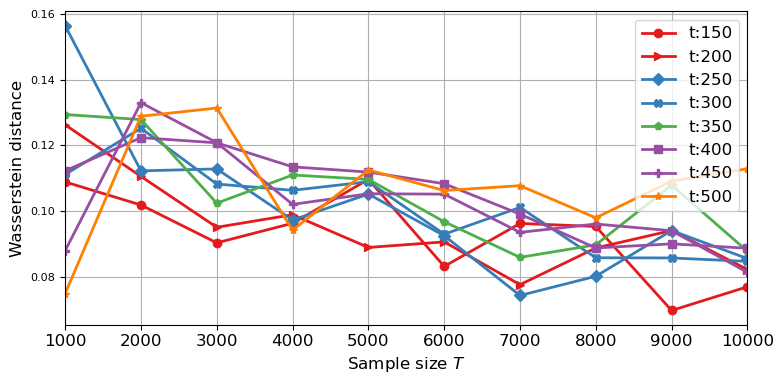

In [48]:

plt.rcParams["figure.figsize"] = (8,4)
colors = plt.cm.Set1(np.linspace(0, .5, 8))
#markers = ['o', '>', 'D', 'X', "p"]
markers = ['o', '>', 'D', 'X', "p", 's', 'P', '*'] 

for i, t in zip(range(len(times_t)), times_t):
    plt.plot(times_T, wass_times_t[f"t:{t}"], label=f"t:{t}", color=colors[i], marker=markers[i], markersize=6, lw=2)
    plt.xlim(np.array(times_T).min(), np.array(times_T).max())
    #plt.title(r'Wasserstein distance $W_1\left(\hat{\pi}_t(\cdot|{x}), \pi_t^\star(\cdot|{x})\right)$')
    plt.xlabel(r'Sample size ${T}$ ')
    plt.ylabel("Wasserstein distance")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    #plt.savefig(path_fig+f"wass_distance{times_t}{times_T}_{n_replications}_kernel_{kernel}", dpi=150)